## Accurate Segmentation of Dermoscopic Images based on Local Binary Pattern Clustering!
https://arxiv.org/pdf/1902.06347.pdf

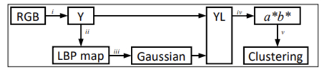

In [29]:
import os
import cv2
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import color
from sklearn.cluster import KMeans
from image import load_image, compare_seg

plt.rcParams['figure.dpi'] = 200

In [30]:
def Y(img):
    n, m, _ = img.shape
    a = np.zeros(shape=(n, m))
    for i in range(n):
        for j in range(m):
            a[i, j] = (img[i, j][0] * 0.2989) + (img[i, j][1] * 0.5870) + (img[i, j][2] * 0.1140)
    return a

def g_index(i, j):
    indexes = []
    for b in range(j - 1, j + 2):
        for a in range(i - 1, i + 2):
            if (a != i) or (b != j):
                indexes.append((a, b))
    return indexes

def sum_lbp(X, i, j):
    def s(x):
        if x > 0:
            return 1
        else:
            return 0
    
    t = 0
    g = g_index(i, j)
    for p in range(7):
        t += s(X[g[p]] - X[i, j]) * (2 ** p)
    return t

def LBP_map(X):
    n, m = X.shape
    a = np.zeros(shape=(n - 2, m - 2))
    for i in range(1, n - 1):
        for j in range(1, m - 1):
            a[i - 1, j - 1] = sum_lbp(X, i, j)
    return a

def LYL(Y_, L_):
    n, m = Y_.shape
    a = np.zeros(shape=(n - 2, m - 2, 3))
    for i in range(1, n - 1):
        for j in range(1, m - 1):
            a[i - 1, j - 1] = np.array([L_[i - 1, j - 1], Y_[i, j], L_[i - 1, j - 1]])
    return a

def ab_tuples(LYL_):
    t = []
    for l in LYL_[:,:,1:3]:
        t += list(l)
    return np.array(t)

def clustering(X, shape):
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    binary_labels = kmeans.labels_
    return binary_labels.reshape(*shape)

def reverse_binary(data):
    x1, y1 = (data == 1).nonzero()
    x2, y2 = (data == 0).nonzero()

    data[x1, y1] = 0
    data[x2, y2] = 1
    return data

def metric2(TPR, FPR):
    return ((1 + (1 - TPR)) ** 2) + ((1 + FPR) ** 2) - 2

def metric1(TPR, FPR):
    return 1 - TPR + FPR

def biggest_contour(img):
    mask = np.zeros(img.shape, np.uint8)
    cnts, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    c_sizes = [(cv2.contourArea(c), c) for c in cnts]
    bc = max(c_sizes, key=lambda x: x[0])[1]
    cv2.drawContours(mask, [bc], -1, 255, -1)
    return mask

def main(filename):
    img = cv2.imread(filename)
    y = Y(img)
    # y = scipy.signal.medfilt2d(y, 3)
    lbp = LBP_map(y)
    gaussian = gaussian_filter(lbp, sigma=4)
    lyl = LYL(y, gaussian)
    lab = color.rgb2lab(lyl)
    X = ab_tuples(lab)
    C = clustering(X, lab.shape[:2]).astype('uint8')
    s = C.shape
    if np.sum(C) > (s[0] * s[1]) / 2:
        C = reverse_binary(C)
    return C * 255

In [31]:
img_folder = "images/original"
seg_folder = "images/segmented"

avg_TPR = 0
avg_FPR = 0
avg_TP = 0
avg_TN = 0
avg_FP = 0
avg_FN = 0
cont = 0

for img_name in sorted(os.listdir(img_folder)):
    cont += 1
    aux_index = img_name.index("i")
    n = img_name[0:aux_index]
    img_path = img_folder + "/" + img_name
    func_seg_img = main(img_path)
    
    # Improve the segmentation by applying morphology operations
    func_seg_img = cv2.erode(func_seg_img, np.ones((5,5),np.uint8), iterations=2)
    func_seg_img = cv2.dilate(func_seg_img, np.ones((5,5),np.uint8), iterations=4)
    
    opening = cv2.morphologyEx(func_seg_img, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
    final = cv2.morphologyEx(opening, cv2.MORPH_DILATE, np.ones((5,5),np.uint8),iterations=3)
    final = cv2.medianBlur(final,9)
    final = cv2.morphologyEx(final, cv2.MORPH_DILATE, np.ones((7,7),np.uint8),iterations=3)
    final = cv2.medianBlur(final,11)
    func_seg_img = cv2.morphologyEx(final, cv2.MORPH_CLOSE, np.ones((7,7),np.uint8))
    
    func_seg_img = biggest_contour(func_seg_img)
                
    real_seg_path = seg_folder + "/" + n + "seg.png"
    real_seg_img = load_image(real_seg_path)
    s = real_seg_img.shape
    real_seg_img = real_seg_img[1:s[0] - 1, 1:s[1] - 1]
    # print(f'[IMG {cont}]')
    # figure, axis = plt.subplots(1, 2)
    # plt.subplots_adjust(hspace=1)
    # axis[0].imshow(func_seg_img, cmap='gray')
    # axis[0].set_title('Segmented')
    # axis[1].imshow(real_seg_img, cmap='gray')
    # axis[1].set_title('Ground Truth')
    # plt.show()
    
    # Compare
    TPR, FPR, TP, TN, FP, FN = compare_seg(real_seg_img, func_seg_img)
    
    # print(f'TPR: {TPR}')
    # print(f'FPR: {FPR}\n')
    print(cont)
    avg_TPR += TPR
    avg_FPR += FPR

print("\n+++++++++\n\n")
avg_TPR = avg_TPR/cont
avg_FPR = avg_FPR/cont   
print("Avg TPR:", avg_TPR)
print("Avg FPR:", avg_FPR)
print("Simple diff: {}".format(metric1(avg_TPR, avg_FPR) * 100))
print("Square diff: {}".format(metric2(avg_TPR, avg_FPR)))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50

+++++++++


Avg TPR: 0.9523775180120022
Avg FPR: 0.13658928765775236
Simple diff: 18.421176964575015
Square diff: 0.38934807358504964


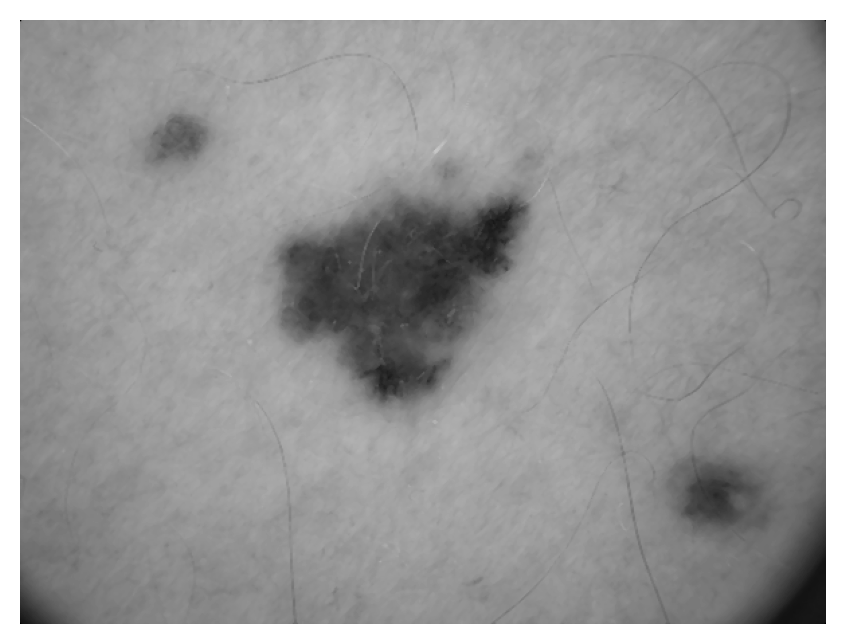

In [28]:
import matplotlib.image as mpimg
import scipy
img_path = "images/original/10img.jpg"
img = mpimg.imread(img_path)
y = Y(img)
y = scipy.signal.medfilt2d(y, 3)
#plt.imshow(img)
plt.axis('off')
plt.imshow(y,cmap="gray",vmin=0,vmax=255)
plt.show()